# Read in the data

In [1]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]
data = {}

for f in data_files:
    key_name = f.replace(".csv", "")
    d = pd.read_csv(f"schools/{f}")
    data[key_name] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey = survey.copy()
survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey[survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg('mean', numeric_only=True)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean(numeric_only=True))
combined = combined.infer_objects(copy=False).fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined = combined.copy()
combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

In [9]:
combined.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,0,129.028846,197.038462,...,Then to New York City residents,0,0,0.0,0.0,0.0,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.713764,-73.985260,01
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.000000,49.000000,...,0,0,0,0.0,0.0,0.0,"200 Monroe Street\nNew York, NY 10002\n(40.712...",40.712332,-73.984797,01
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.000000,21.000000,...,0,0,0,0.0,0.0,0.0,"420 East 12 Street\nNew York, NY 10009\n(40.72...",40.729783,-73.983041,01
3,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0,0,129.028846,197.038462,...,0,0,0,0.0,0.0,0.0,"145 Stanton Street\nNew York, NY 10002\n(40.72...",40.720569,-73.985673,01
4,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159,522.0,574.0,525.0,1621.0,"NEW EXPLORATIONS SCI,TECH,MATH",255.000000,377.000000,...,0,0,0,0.0,0.0,0.0,"111 Columbia Street\nNew York, NY 10002\n(40.7...",40.718725,-73.979426,01


Lots of columns because of all the combined dfs! Need to keep this in mind. 

In [10]:
# Export the csv
combined.to_csv('the_dataset.csv')

# Find correlations

In [11]:
correlations = combined.corr(numeric_only=True)
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


Tooooo many columns above to really get inside. Instead, we can focus on the strongest negative and positive correlations with the SAT score:

In [12]:
correlations = combined.corr(numeric_only=True)
correlations_asc = correlations["sat_score"].sort_values()
correlations_desc = correlations['sat_score'].sort_values(ascending=False)
print('Top 5 negative correlations:\n', correlations_asc.head())
print('\nTop 10 positive correlations:\n', correlations_desc.head(10))

Top 5 negative correlations:
 frl_percent    -0.722225
sped_percent   -0.448170
ell_percent    -0.398750
hispanic_per   -0.396985
black_per      -0.284139
Name: sat_score, dtype: float64

Top 10 positive correlations:
 sat_score                               1.000000
SAT Writing Avg. Score                  0.987771
SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
white_per                               0.620718
asian_per                               0.570730
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
asian_num                               0.475445
Number of Exams with scores 3 4 or 5    0.463245
Name: sat_score, dtype: float64


Note: It makes sense that the high specific SAT scores would be highly correlated with strong SAT scores overall. 

# Plotting survey correlations

The survey was given to students, parents, and teachers. 

In [13]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

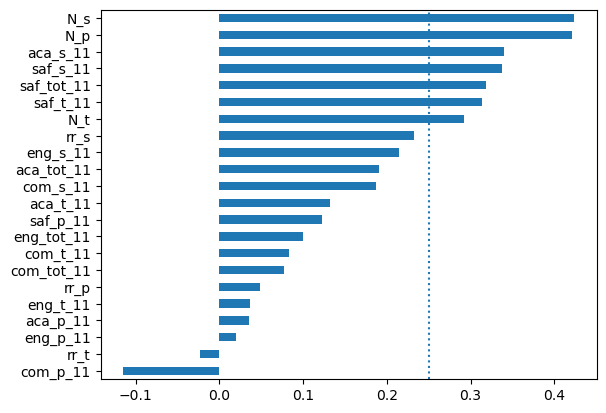

In [18]:
import matplotlib.pyplot as plt

# render graphs within jupyter
%matplotlib inline

survey_corrs = correlations["sat_score"][survey_fields].sort_values()

# barh() is for horizontal bars
survey_corrs.plot.barh()
plt.axvline(0.25, linestyle=":")
plt.show()

#combined.corr(numeric_only=True)["sat_score"][survey_fields].sort_values().plot.barh()

This helps us visualize the strongest correlations. 
- N_p: Number of students who responded to survey
- N-p: Number of parents who responded to survey
    - Maybe these are more involved
- aca_s_11: Academic perception of students in 11th grade (do you think academics are important?)
- saf_s_11: Perception in grade 11 of if safety is important


In [ ]:
# Looking at student-perceived safety vs sat_score

# Insert scatterplot

## Safety and SAT Scores
Is there a connection between borough and safety? If so, that could impact SAT scores because student perception of safety and SAT scores were correlated. 

In [21]:
borough_safety = combined.groupby('boro').mean(numeric_only=True)
display(borough_safety[['saf_s_11', 'saf_p_11', 'saf_t_11', 'saf_tot_11', 'sat_score']].sort_values(by='sat_score'))

,saf_s_11,saf_p_11,saf_t_11,saf_tot_11,sat_score
boro,,,,,
Bronx,6.606577,8.346237,7.026882,7.322581,1157.598203
Brooklyn,6.370755,8.036792,6.985849,7.129245,1181.364461
Manhattan,6.831370,8.288889,7.287778,7.473333,1278.331410
Queens,6.721875,8.098437,7.365625,7.387500,1286.753032
Staten Island,6.530000,7.800000,7.210000,7.200000,1382.500000


Note: Pretty significant spread in SAT scores, but not really with safety... 
Could try something else instead of borough, such as school district. Smaller regions - boroughs might be too large. 

What about race? 

## Race and SAT Scores

<Axes: >

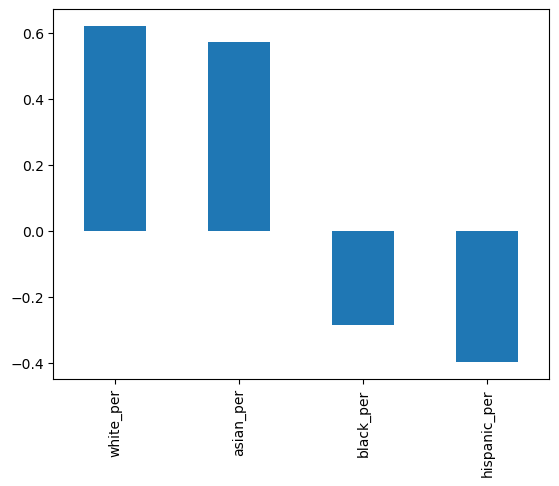

In [23]:
race_fields = ["white_per", "asian_per", "black_per", "hispanic_per"]
combined.corr(numeric_only=True)["sat_score"][race_fields].plot.bar()

In [ ]:
import numpy as np

combined.plot.scatter('hispanic_per', 'sat_score')

# Add trend line
x = combined['hispanic_per']
y = combined['sat_score']
slope, intercept = np.polyfit(x, y, 1)

### Missing code here

What if we check out the schools with the highest proportion of hispanic students?

In [ ]:
# missing code
# combined[['SCHOOL NAME', "Num of SAT Test Takers", "hispanic_per", "sat_score", "sped_percent", "ell_percent", "school_dist"]]

Note: most of these schools have high % of ell except "Washington Heights Expeditionary Learning School". Hmmm why? (google)

NYC's "Outward Bound" program focuses on English learners. So, if most Ss at your school are ELL, the SAT is going to be more challenging.

What about schools with low % of hispanic students and high SAT scores? They have very low percentages of hispanic students, ELL students, and sped. The top 5 schools in this group are specialized schools for gifted learners. 

What about gender?

## Gender and SAT Scores

In [ ]:
gender_fields = ["male_per", "female_per"]
# unfinished
# combined.corr(numeric_only=True)


Only -10% for male and 10% for female, so 20 percentage points between them

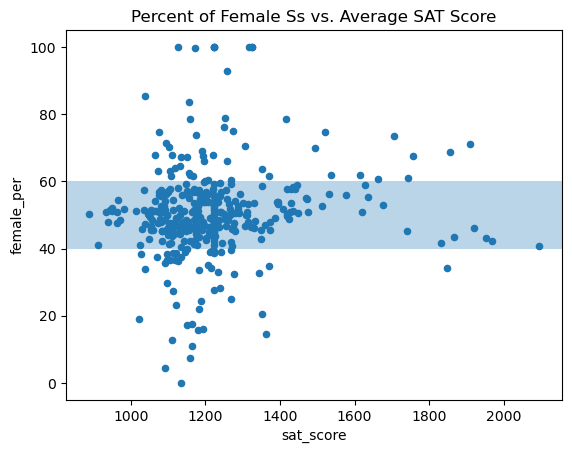

In [24]:
combined.plot.scatter("sat_score", "female_per")
plt.axhspan(40,60, alpha=0.3) #alpha sets transparency
plt.title("Percent of Female Ss vs. Average SAT Score")
plt.show()

Graph shows a subtantial numebr of schools well above/below expected gender proportions. 

So, what is average SAT score for many-girl schools vs many-boy schools?

In [25]:
fem_60 = round(combined('sat_score')[combined['female_per']>60].mean(),2)
fem_40 = round(combined('sat_score')[combined['female_per']<40].mean(),2)
print("Average SAT for >60% female schools: ", fem_60)
print("Average SAT for <40% female schools: ", fem_40)

TypeError: 'DataFrame' object is not callable

If you look at these schools, they all have academic requirements to enrol. A lot are also liberal arts schools that tend to have more female students. 

## AP vs the SAT

Note the vertical line in the scatter plot - it was the mean used to fill in missing data. 

Not much of a trend. There might be two clusters though? The lower left and the higher right?

In [26]:
# need earlier cells first
#combined[["sat_score", "ap_per"]].corr()

KeyError: "['ap_per'] not in index"

What else could be done in this project? There are 170 columns... Other correlations that were strong but we haven't looked at yet. Maybe we could delve into safety and distric, or split the AP results into groups and examine those groups. 

What to check out: 
- class size
- which neighborhoods have best schools? Are they consistently better?
- What about property values, could we add that in? Could you find a place with cheap housing but good schools?
- Assign scores to schools based on sat_score and other attributes (a la College Board). Attendance, safety, college acceptance


Other resources on Data Quest for sharing projects via GitHub etc. 